# Time Series Modeling: Spain Energy Data

## Prepare Notebook

**Read in libraries**

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

**Set Notebook Preferences**

In [79]:
#Set Pandas preferenes
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

#Set style for matplotlib and fontdict for plots
plt.style.use('seaborn-dark')
title_dict= {'fontsize':18,
            'style': 'italic',
            'fontweight': 'semibold'}

label_dict= {'fontsize':14,
             'fontweight': 'semibold'}

#Surpress annoying warnings
import warnings
warnings.filterwarnings('ignore')

**Read in data**

In [80]:
#Set path to data
path = r'\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Data\03_Processed_Data'

#Read in training and test data
X_train = pd.read_csv(path + '/2020_0624_Training_Data.csv', index_col=0)
X_test = pd.read_csv(path + '/2020_0624_Test_Data.csv', index_col=0)

#Read in price forecasts data
price_forecasts = pd.read_csv(path + '/2020_0620_Data_Price_Forecasts.csv', index_col=0)

**Preview Data**

In [81]:
print('Training data shape:', X_train.shape)
display(X_train.head())

print('\nTest data shape:',X_test.shape)
display(X_test.head())

print('\nPrice forecasts shape:',price_forecasts.shape)
display(price_forecasts.head())

Training data shape: (29789, 43)


,generation_fossil_gas,generation_fossil_gas_stationary,generation_fossil_hard_coal,generation_fossil_hard_coal_stationary,generation_hydro_pumped_storage_consumption,generation_hydro_pumped_storage_consumption_stationary,price_actual,price_actual_season,price_actual_stationary,price_actual_trend,total_load_actual,total_load_actual_stationary,year,month,week_number_year,weekday,day,is_weekend,holiday,price_actual_lag_1,price_actual_lag_2,price_actual_lag_3,price_actual_lag_4,price_actual_lag_5,price_actual_lag_6,price_actual_lag_7,price_actual_lag_8,price_actual_lag_9,price_actual_lag_10,price_actual_lag_11,price_actual_lag_12,price_actual_lag_13,price_actual_lag_14,price_actual_lag_15,price_actual_lag_16,price_actual_lag_17,price_actual_lag_18,price_actual_lag_19,price_actual_lag_20,price_actual_lag_21,price_actual_lag_22,price_actual_lag_23,price_actual_lag_24
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 12:00:00,3784.0,-821.652818,4220.0,-134.521023,972.0,131.336181,60.12,3.750959,-5.750750,62.119792,24133.0,-2151.597351,2015,January,1,Thursday,1,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 13:00:00,3754.0,-788.106788,4404.0,159.169985,922.0,81.075629,62.05,3.292118,-3.198368,61.956250,24713.0,-2121.835430,2015,January,1,Thursday,1,False,True,-5.750750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 14:00:00,3779.0,-633.241441,4256.0,159.104975,941.0,30.936512,62.06,2.675646,-2.233563,61.617917,24672.0,-2332.248460,2015,January,1,Thursday,1,False,True,-3.198368,-5.750750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 15:00:00,3708.0,-568.192702,4038.0,101.672295,1069.0,50.314849,59.76,1.874951,-3.437243,61.322292,23528.0,-3348.148129,2015,January,1,Thursday,1,False,True,-2.233563,-3.198368,-5.750750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 16:00:00,3813.0,-363.724387,4191.0,415.279699,970.0,-168.099337,61.18,1.011884,-1.000426,61.168542,23118.0,-3455.914328,2015,January,1,Thursday,1,False,True,-3.437243,-2.233563,-3.198368,-5.75075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Test data shape: (5257, 43)


,generation_fossil_gas,generation_fossil_gas_stationary,generation_fossil_hard_coal,generation_fossil_hard_coal_stationary,generation_hydro_pumped_storage_consumption,generation_hydro_pumped_storage_consumption_stationary,price_actual,price_actual_season,price_actual_stationary,price_actual_trend,total_load_actual,total_load_actual_stationary,year,month,week_number_year,weekday,day,is_weekend,holiday,price_actual_lag_1,price_actual_lag_2,price_actual_lag_3,price_actual_lag_4,price_actual_lag_5,price_actual_lag_6,price_actual_lag_7,price_actual_lag_8,price_actual_lag_9,price_actual_lag_10,price_actual_lag_11,price_actual_lag_12,price_actual_lag_13,price_actual_lag_14,price_actual_lag_15,price_actual_lag_16,price_actual_lag_17,price_actual_lag_18,price_actual_lag_19,price_actual_lag_20,price_actual_lag_21,price_actual_lag_22,price_actual_lag_23,price_actual_lag_24
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-26 14:00:00,6048.0,24.309123,4527.0,-24.743331,194.0,129.695125,66.61,0.535144,-0.877644,66.952500,27714.0,582.731434,2018,May,21,Saturday,26,True,False,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-1.773162,-0.300561
2018-05-26 15:00:00,5663.0,-418.343756,4094.0,-439.425570,194.0,129.664444,60.59,0.799412,-7.262954,67.053542,26342.0,-484.686927,2018,May,21,Saturday,26,True,False,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-1.773162
2018-05-26 16:00:00,5466.0,-730.323850,3676.0,-872.340738,463.0,447.250389,56.99,2.340335,-12.490127,67.139792,25461.0,-1355.937712,2018,May,21,Saturday,26,True,False,-7.262954,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918
2018-05-26 17:00:00,5289.0,-1068.997594,3610.0,-968.334274,492.0,552.085877,56.71,4.743248,-15.208039,67.174792,25063.0,-2007.453351,2018,May,21,Saturday,26,True,False,-12.490127,-7.262954,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623
2018-05-26 18:00:00,5351.0,-1106.621481,3880.0,-712.198986,280.0,402.886319,59.06,5.793649,-13.923441,67.189792,24944.0,-2213.977153,2018,May,21,Saturday,26,True,False,-15.208039,-12.490127,-7.262954,-0.877644,1.307907,0.785257,0.276229,-0.425243,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566



Price forecasts shape: (35070, 1)


,price_forecast
date_time,
2015-01-01 00:00:00,50.10
2015-01-01 01:00:00,48.10
2015-01-01 02:00:00,47.33
2015-01-01 03:00:00,42.27
2015-01-01 04:00:00,38.41


# Modeling

### Evaluate original price forecast performance

**Prepare price_forecasts data**

In [82]:
#Split forecasts to evaluate predictions on train/test data
cutoff = round(len(price_forecasts) *.85)
price_train = price_forecasts.price_forecast[:cutoff]
price_test = price_forecasts[cutoff:]

#Check label shapes
print('Train label shape{} Test label shape: {}'.format(price_train.shape,price_test.shape))

Train label shape(29810,) Test label shape: (5260, 1)


**Evaluate fit and performance**

Original Price Model Performance Metrics
MAE:11.568358444037331
MAPE:16.530011046046493%
MSE:229.38034309036792
RMSE:15.145307626138464


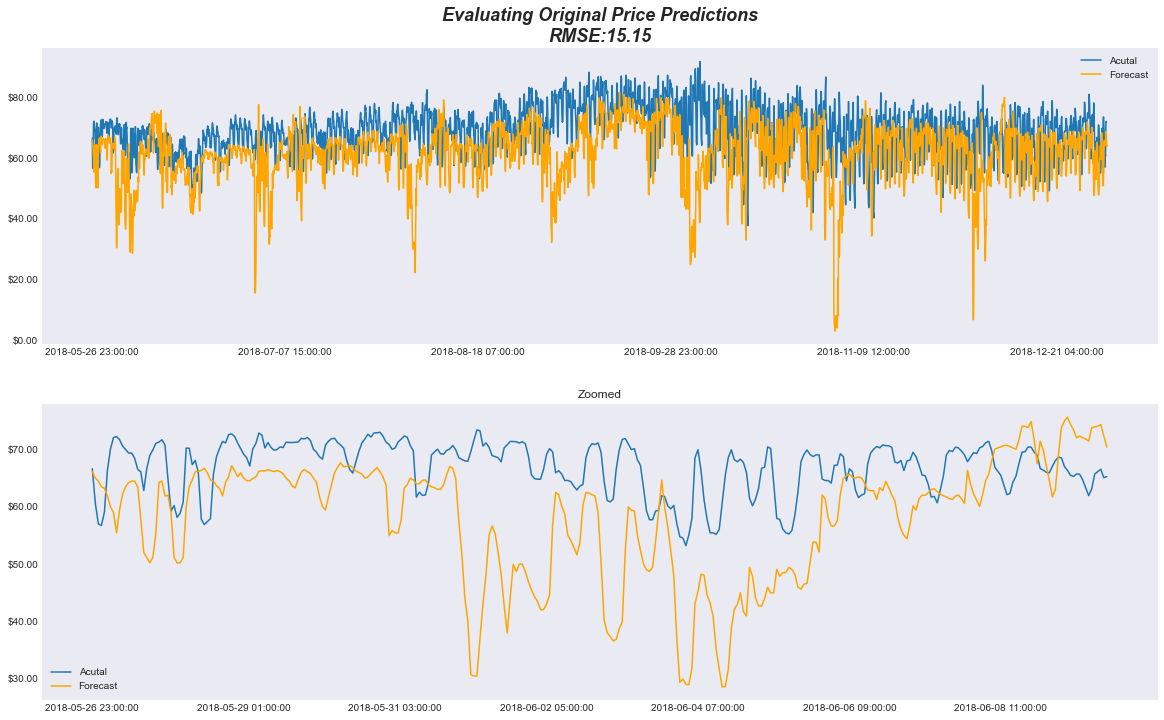

In [83]:
#Read in model_performance to capture metrics and timeseries_plot to plot timeseries
from TimeSeriesStats import model_performance
from TimeseriesPlotter import timeseries_plot

#Capture predictions
predictions = price_test.values
actual = X_test['price_actual'].values

#Evaluate price preditions
metrics = model_performance(predictions, actual, 'Original Price Model')

#Create fig
f, ax = plt.subplots(2,1,figsize = (20,12))

#Plot original data
timeseries_plot(X_test['price_actual'], ax = ax[0])
timeseries_plot(price_test,title='Evaluating Original Price Predictions\nRMSE:{}'.format(round(metrics['RMSE'],2)), 
                title_dict=title_dict, color = 'orange', ax = ax[0])

#Plot zoomed data
timeseries_plot(X_test['price_actual'][:24*14], ax = ax[1])
timeseries_plot(price_test[:24*14],title='Zoomed', 
                 color = 'orange', ax = ax[1])

###Set plot aesthetics###
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))));
ax[0].legend(['Acutal', 'Forecast'], shadow = True)

ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))));
ax[1].legend(['Acutal', 'Forecast'], shadow = True);

## Univariate Analysis

**Prepare data for univariate analysis**

In [84]:
X_train.head(2)

,generation_fossil_gas,generation_fossil_gas_stationary,generation_fossil_hard_coal,generation_fossil_hard_coal_stationary,generation_hydro_pumped_storage_consumption,generation_hydro_pumped_storage_consumption_stationary,price_actual,price_actual_season,price_actual_stationary,price_actual_trend,total_load_actual,total_load_actual_stationary,year,month,week_number_year,weekday,day,is_weekend,holiday,price_actual_lag_1,price_actual_lag_2,price_actual_lag_3,price_actual_lag_4,price_actual_lag_5,price_actual_lag_6,price_actual_lag_7,price_actual_lag_8,price_actual_lag_9,price_actual_lag_10,price_actual_lag_11,price_actual_lag_12,price_actual_lag_13,price_actual_lag_14,price_actual_lag_15,price_actual_lag_16,price_actual_lag_17,price_actual_lag_18,price_actual_lag_19,price_actual_lag_20,price_actual_lag_21,price_actual_lag_22,price_actual_lag_23,price_actual_lag_24
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 12:00:00,3784.0,-821.652818,4220.0,-134.521023,972.0,131.336181,60.12,3.750959,-5.750750,62.119792,24133.0,-2151.597351,2015,January,1,Thursday,1,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 13:00:00,3754.0,-788.106788,4404.0,159.169985,922.0,81.075629,62.05,3.292118,-3.198368,61.956250,24713.0,-2121.835430,2015,January,1,Thursday,1,False,True,-5.75075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
#Set Univariate variable for model training
X_train_univariate = X_train['price_actual_stationary']

#Set actual as target
actual = X_test['price_actual']

#Check
print('Univariate training data shape{}\nLabel shape{}\n'.format(X_train_univariate.shape,actual.shape))
display(X_train_univariate.head())

Univariate training data shape(29789,)
Label shape(5257,)



date_time
2015-01-01 12:00:00   -5.750750
2015-01-01 13:00:00   -3.198368
2015-01-01 14:00:00   -2.233563
2015-01-01 15:00:00   -3.437243
2015-01-01 16:00:00   -1.000426
Name: price_actual_stationary, dtype: float64

### Holt-Winters Exponential Smoothing

**Build HW Model**

In [86]:
#Import holt winters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Init model
holt_winters = ExponentialSmoothing(X_train_univariate.values,seasonal='add', seasonal_periods=12).fit(smoothing_level=0.8, smoothing_slope=0.2)

#Make predictions
holt_preds = holt_winters.forecast(len(actual))

**Convert predictions back to proper scale**

In [87]:
#Store predictions and test values in a dataframe
evaluate_hw = pd.DataFrame(holt_preds, index=actual.index)
evaluate_hw.columns = ['hw_preds']
evaluate_hw['actual'] = actual.values

#Add seasonal and trend components to hw_preds
evaluate_hw['adjusted_preds'] = evaluate_hw['hw_preds'] + X_test['price_actual_season'] + X_test['price_actual_trend']

#Check
display(evaluate_hw)

,hw_preds,actual,adjusted_preds
date_time,,,
2018-05-26 14:00:00,0.654029,66.61,68.141673
2018-05-26 15:00:00,-1.049062,60.59,66.803892
2018-05-26 16:00:00,-4.007850,56.99,65.472277
2018-05-26 17:00:00,-7.100664,56.71,64.817375
2018-05-26 18:00:00,-9.101818,59.06,63.881622
...,...,...,...
2018-12-31 07:00:00,-3.108427,60.70,68.332649
2018-12-31 08:00:00,-1.765656,66.64,69.214366
2018-12-31 09:00:00,0.213476,70.33,70.465094


**Evaluate Holt Winter's Predictions**

Holt Winter's Performance Metrics
MAE:4.945704618595356
MAPE:7.101842138388184%
MSE:36.79915671838181
RMSE:6.066230849413976


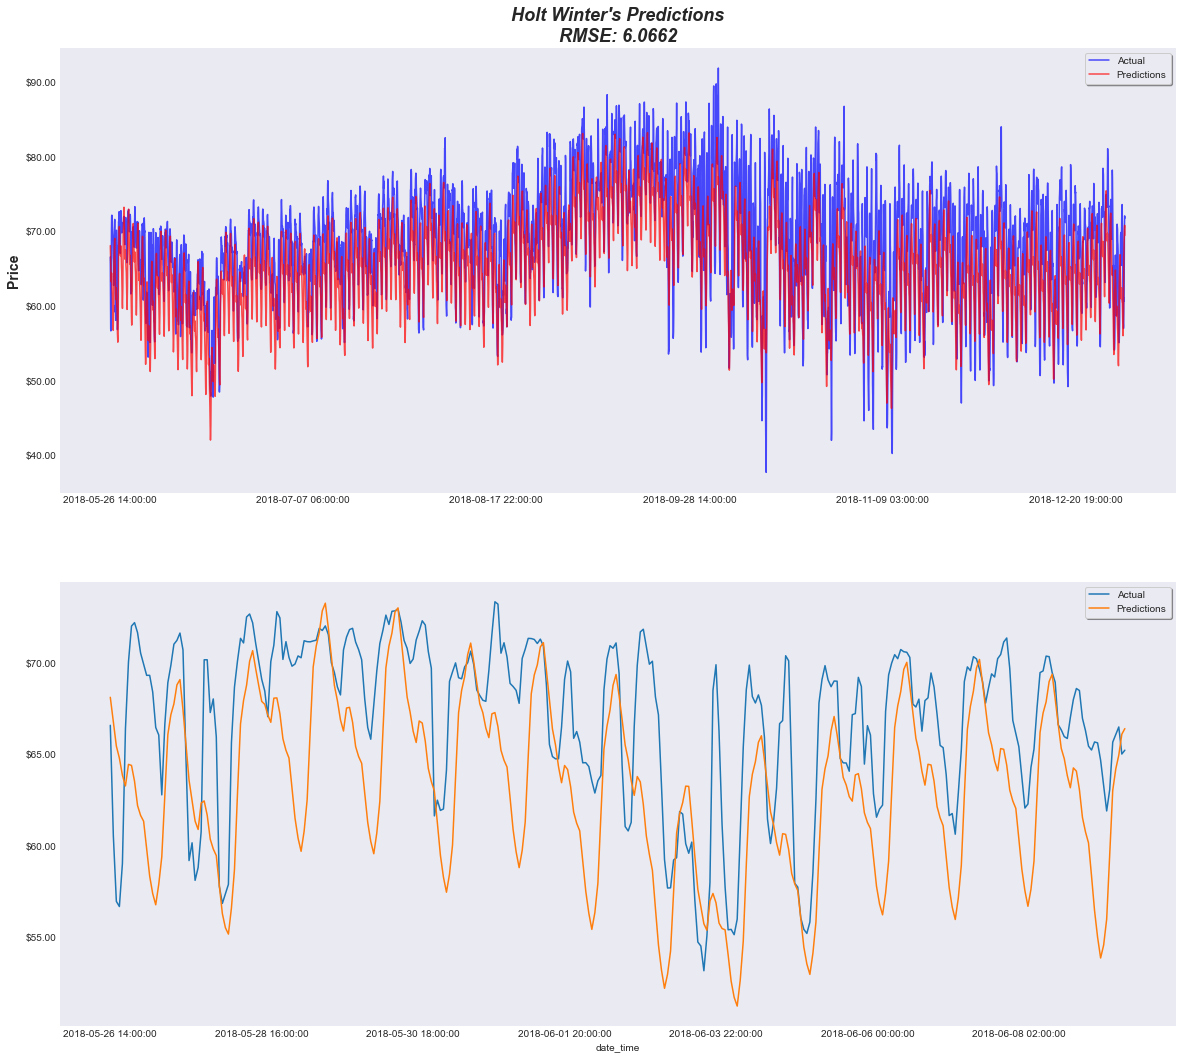

In [88]:
#Evaluate metrics
hw_metrics = model_performance(evaluate_hw.adjusted_preds.values, evaluate_hw.actual.values, 'Holt Winter\'s')

#Create fig to plot data to evaluate fit
f,ax = plt.subplots(2,1,figsize = (20,18))

#Plot predictions against test data
timeseries_plot(evaluate_hw.actual, ax=ax[0], color = 'blue',alpha=.7)
timeseries_plot(evaluate_hw.adjusted_preds, ax=ax[0], 
                title ='Holt Winter\'s Predictions\nRMSE: {}'.format(round(hw_metrics['RMSE'],4)),
                title_dict=title_dict,ylabel='Price', color = 'red',label_dict=label_dict,alpha=.7)

###Set plot aesthetics**
ax[0].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[0].legend(['Actual','Predictions'], frameon = True, shadow = True)

#Plot predictions against test data(zoomed)
evaluate_hw.actual[:24*14].plot( ax=ax[1])
evaluate_hw.adjusted_preds[:24*14].plot( ax=ax[1])


ax[1].get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "${:}.00".format(int(x))))
ax[1].legend(['Actual','Predictions'], frameon = True, shadow = True)

### ARMA Model 

**PACF and ACF of Stationary Target**

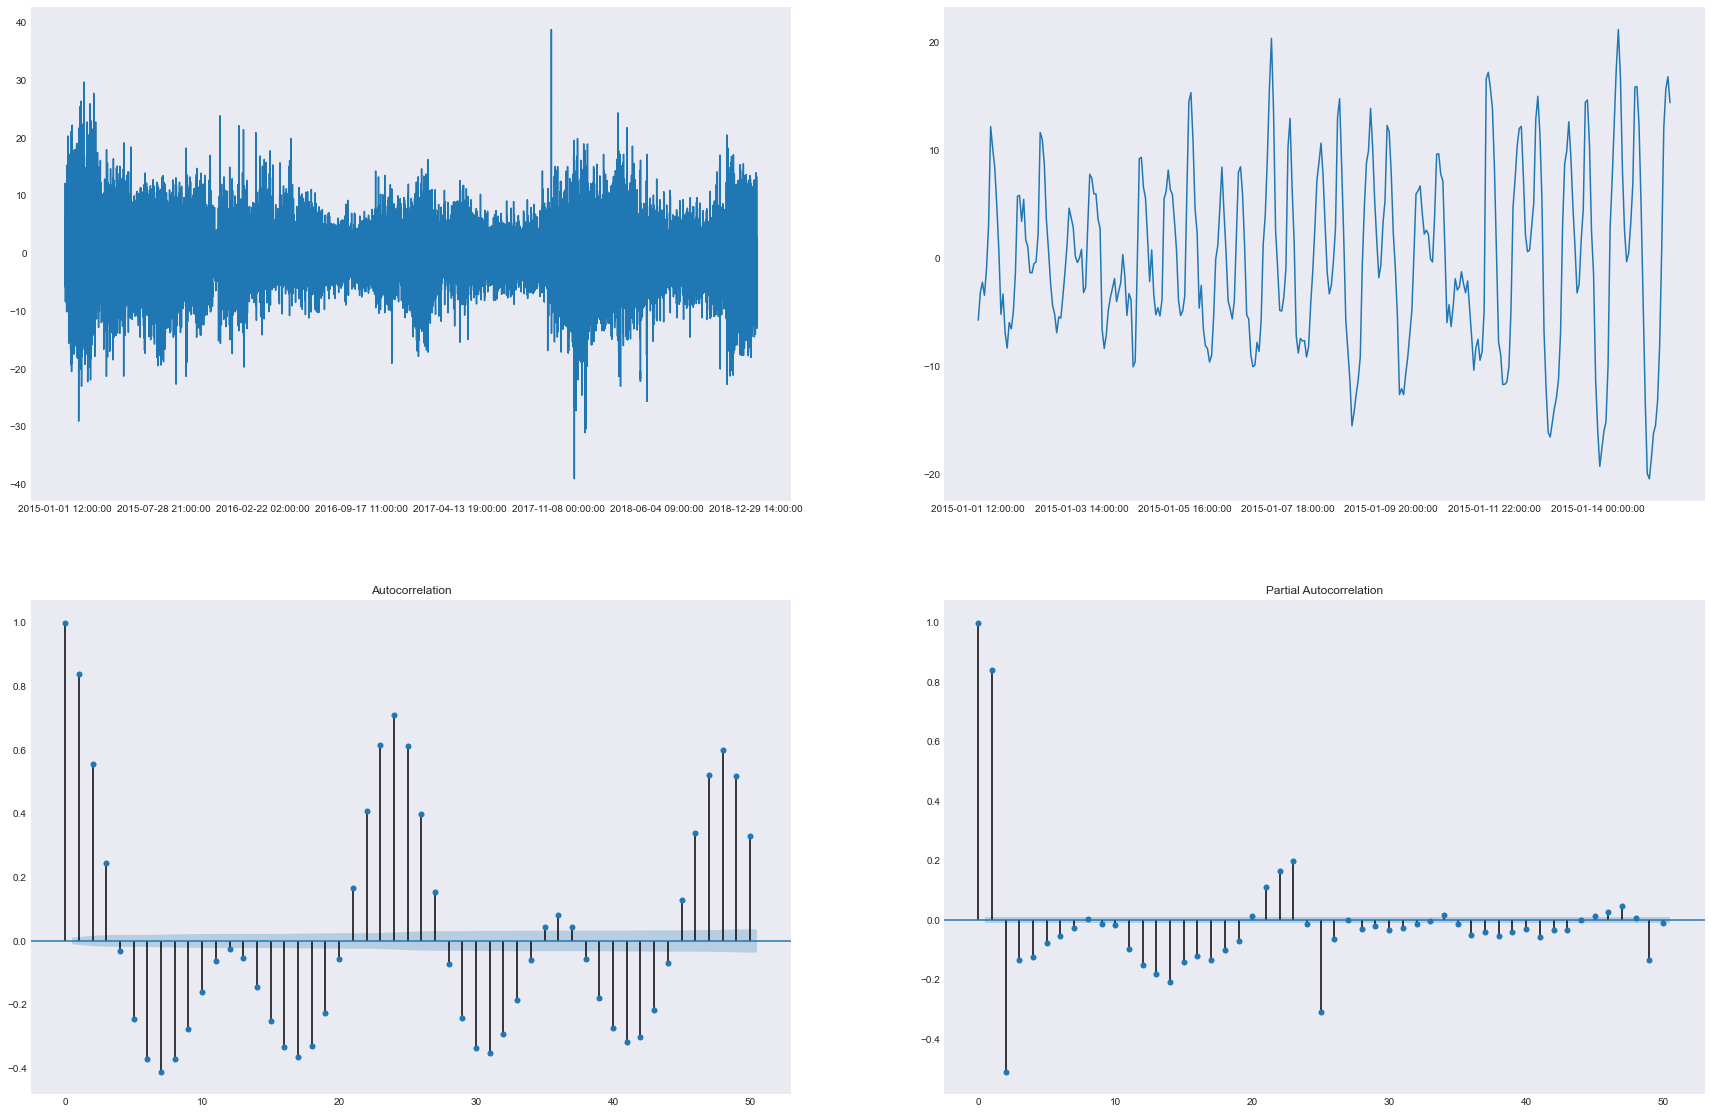

In [89]:
#Set path
viz_path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Spain Hourly Energy Demand and Weather\Visualizations\02_Data_Processing'

#Read in image
Image(filename= viz_path + '/stationary_target_PACF_ACF.png', height=1300, width=1500)

**Build ARMA Model**

In [90]:
#Import library
from statsmodels.tsa.arima_model import ARIMA

#Build, fit, and view ARMA summary
model = ARIMA(X_train_univariate.values, order=(2,0,1))
model_fitted = model.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                29789
Model:                     ARMA(2, 1)   Log Likelihood              -71550.292
Method:                       css-mle   S.D. of innovations              2.672
Date:                Mon, 29 Jun 2020   AIC                         143110.585
Time:                        07:50:39   BIC                         143152.094
Sample:                             0   HQIC                        143123.908
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.046      0.018      0.986      -0.090       0.092
ar.L1.y        1.5549      0.008    184.471      0.000       1.538       1.571
ar.L2.y       -0.7434      0.007   -109.286      0.000      -0.757      -0.730
ma.L1.y       -0.4345      0.013    -34.227      0.000      -0.459      -0.410
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0459           -0.5014j            1.1599           -0.0711
AR.2            1.0459           +0.5014j            1.1599            0.0711
MA.1            2.3013           +0.0000j            2.3013            0.0000
-----------------------------------------------------------------------------
"""

**Make and convert ARMA forecasts to proper scale**

In [91]:
#Create forecast
fc,se,conf = model_fitted.forecast(len(actual))

#Create arma_forecasts df to contain forecasts, upper/lower confidence intervals
arma_forecasts = pd.DataFrame(fc, index=actual.index)
arma_forecasts.columns = ['forecasts']
arma_forecasts['upper_conf']= conf[:,1] #add upper and lower confidence intervals to predictions
arma_forecasts['lower_conf'] =  conf[:,0]

#For loop converts columns in arma_forecasts to proper scale
for col in arma_forecasts.columns:
    arma_forecasts[col + '_adjusted'] = arma_forecasts[col] + X_test['price_actual_season'] + X_test['price_actual_trend']

#Add target to arma_forecasts and sort columns
arma_forecasts['actual']=actual
arma_forecasts = arma_forecasts.reindex(sorted(arma_forecasts.columns), axis=1)

#Check
display(arma_forecasts.head())

,actual,forecasts,forecasts_adjusted,lower_conf,lower_conf_adjusted,upper_conf,upper_conf_adjusted
date_time,,,,,,,
2018-05-26 14:00:00,66.61,1.305928,68.793572,-3.931651,63.555993,6.543506,74.031150
2018-05-26 15:00:00,60.59,1.058526,68.911480,-6.806994,61.045960,8.924047,76.777001
2018-05-26 16:00:00,56.99,0.675310,70.155437,-8.770823,60.709304,10.121444,79.601571
2018-05-26 17:00:00,56.71,0.263348,72.181388,-9.907928,62.010112,10.434624,82.352664
2018-05-26 18:00:00,59.06,-0.092352,72.891088,-10.453821,62.529620,10.269116,83.252557


**Evaluate ARMA Forecasts**

ARIMA Performance Metrics
MAE:4.325886697302129
MAPE:6.587730820723476%
MSE:31.857276805700337
RMSE:5.644225084606419


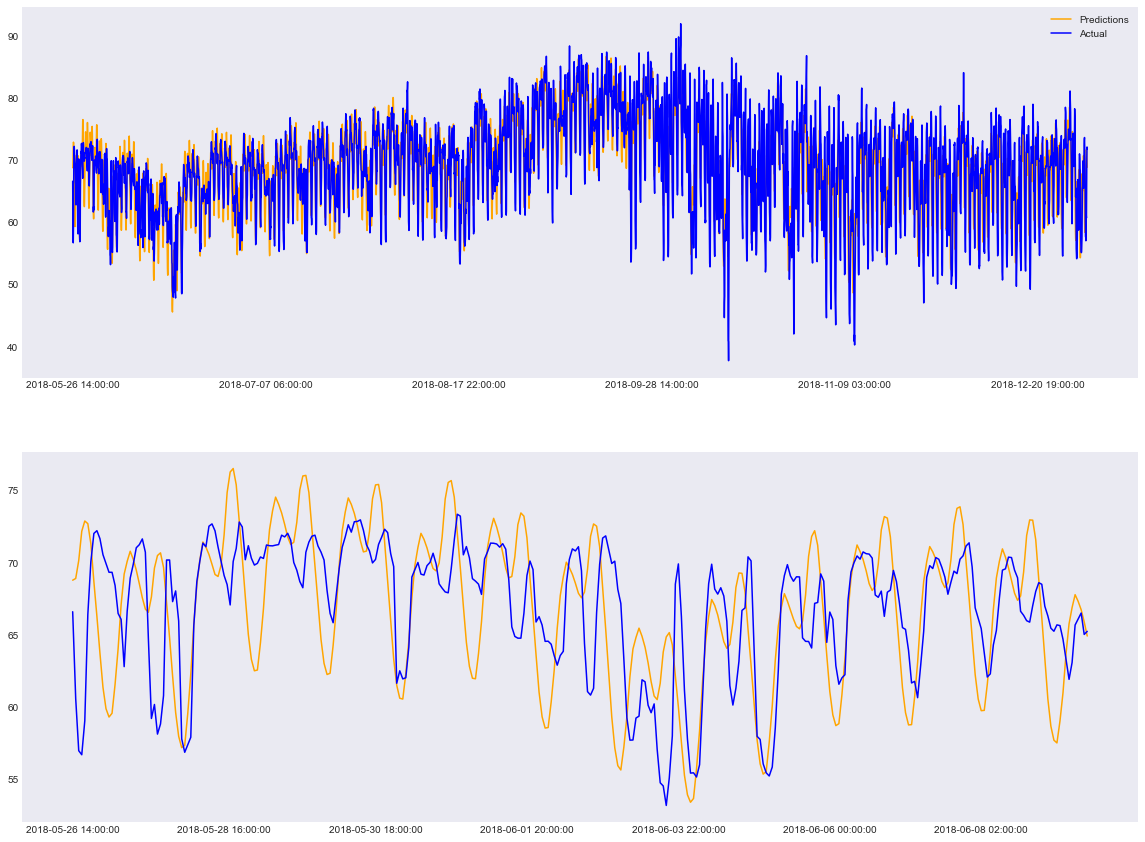

In [92]:
#Evaluate ARIMA's Performance
arima_metrics = model_performance(arma_forecasts['forecasts_adjusted'].values,actual,'ARIMA')

#Set Figure
f, ax = plt.subplots(2,1,figsize = (20,15))

#Plot Forecasts
timeseries_plot(arma_forecasts['forecasts_adjusted'], ax = ax[0], color = 'orange')
timeseries_plot(actual, ax = ax[0], color = 'blue')
ax[0].legend(['Predictions','Actual'])


timeseries_plot(arma_forecasts['forecasts_adjusted'][:24*14], ax = ax[1],color = 'orange')
timeseries_plot(actual[:24*14], ax = ax[1],color = 'blue')

**Check Residuals**

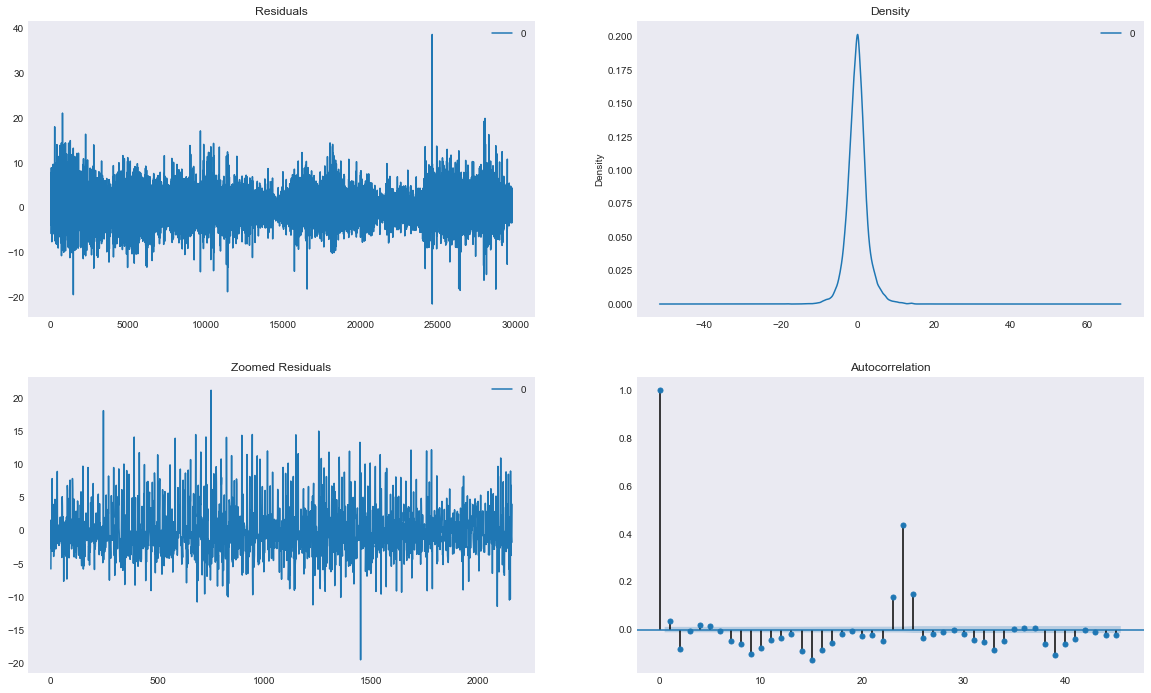

In [93]:
#Check residuals
from statsmodels.graphics.tsaplots import plot_acf


residuals = pd.DataFrame(model_fitted.resid)
fig, ax = plt.subplots(2,2, figsize = (20,12))
residuals.plot(title="Residuals", ax=ax[0,0])
residuals.plot(kind='kde', title='Density', ax=ax[0,1])
residuals[:24*90].plot(title="Zoomed Residuals", ax=ax[1,0])
plot_acf(residuals, ax=ax[1,1])

plt.show()

### XGBoost on Univariate Data

**Prepare data**

In [94]:
#Read in libraries
import xgboost as xgb
from xgboost.sklearn import XGBRegressor


### Multivariate Analysis - Vector Autoregression

In [95]:
#Subset stationary features for multivariate analysis
X_train_multivariate = X_train.filter(regex='stationary')

#Check
print('Multivariate training data shape:{}'.format(X_train_multivariate.shape))

Multivariate training data shape:(29789, 5)


In [96]:
#Read in and init VARMAX
from statsmodels.tsa.api import VAR

#Init VAR model
model = VAR(X_train_multivariate)

#Find optimal value for P
display(model.select_order(maxlags=24).summary())

#Fit model with maxlags = 24
model_fitted = model.fit(24)

,AIC,BIC,FPE,HQIC
0,56.07,56.07,2.236e+24,56.07
1,50.20,50.21,6.360e+21,50.21
2,49.04,49.05,1.978e+21,49.04
3,48.99,49.02,1.894e+21,49.00
4,48.93,48.96,1.780e+21,48.94
5,48.90,48.94,1.724e+21,48.91
6,48.87,48.92,1.680e+21,48.89
7,48.85,48.90,1.643e+21,48.87
8,48.82,48.88,1.598e+21,48.84
9,48.79,48.86,1.554e+21,48.82


**Check for serial correlation**

In [97]:
#Import durbin_watson
from statsmodels.stats.stattools import durbin_watson

#Init durbin_watson and get serial correlation results
serial_corr = durbin_watson(model_fitted.resid)

#View results
for col,value in zip(X_train_multivariate.columns, serial_corr):
    print(col, 'DW Statistic:', round(value,3))

generation_fossil_gas_stationary DW Statistic: 2.021
generation_fossil_hard_coal_stationary DW Statistic: 1.995
generation_hydro_pumped_storage_consumption_stationary DW Statistic: 2.015
price_actual_stationary DW Statistic: 2.02
total_load_actual_stationary DW Statistic: 2.04


**Forecast Predictions w/ VAR**

In [98]:
#Prepare input data, making sure to invert time series
lag_order = model_fitted.k_ar
var_input_data = X_train_multivariate.values[-lag_order:]

#Make forecast
forecast = model_fitted.forecast(var_input_data, steps = len(X_test))

**Convert forecasts and evaluate performance on target**

In [99]:
#Create a dataframe of forecast values
var_forecasts = pd.DataFrame(forecast, index=actual.index[-len(actual):], columns=X_train_multivariate.columns)

#Subset trend and season values from X_test
trend_season = X_test.filter(regex='season|trend')

#Concatenate and sort columns alphabetically
var_forecasts = pd.concat([var_forecasts,trend_season], axis = 1)
var_forecasts = var_forecasts.reindex(sorted(var_forecasts.columns), axis = 1)

#Convert predictions on price_actual
var_forecasts['price_actual_predictions'] = var_forecasts['price_actual_stationary'] + var_forecasts['price_actual_season'] + var_forecasts['price_actual_trend']

#Check
display(var_forecasts.head())

,generation_fossil_gas_stationary,generation_fossil_hard_coal_stationary,generation_hydro_pumped_storage_consumption_stationary,price_actual_season,price_actual_stationary,price_actual_trend,total_load_actual_stationary,price_actual_predictions
date_time,,,,,,,,
2018-05-26 14:00:00,-129.228745,4.812374,145.799430,0.535144,0.318547,66.952500,852.693296,67.806191
2018-05-26 15:00:00,-211.953160,-80.643442,207.958736,0.799412,-1.952381,67.053542,521.474252,65.900573
2018-05-26 16:00:00,-219.275990,-114.083722,304.135531,2.340335,-4.388437,67.139792,-35.160998,65.091690
2018-05-26 17:00:00,-277.126660,-165.178367,334.073717,4.743248,-5.953971,67.174792,-775.352274,65.964069
2018-05-26 18:00:00,-298.615695,-199.575195,300.449019,5.793649,-6.359934,67.189792,-1307.041700,66.623506


**Plot Forecasts to see fit**

VAR Performance Metrics
MAE:4.265074643430418
MAPE:6.495307878186127%
MSE:31.180247664444657
RMSE:5.583927619914558


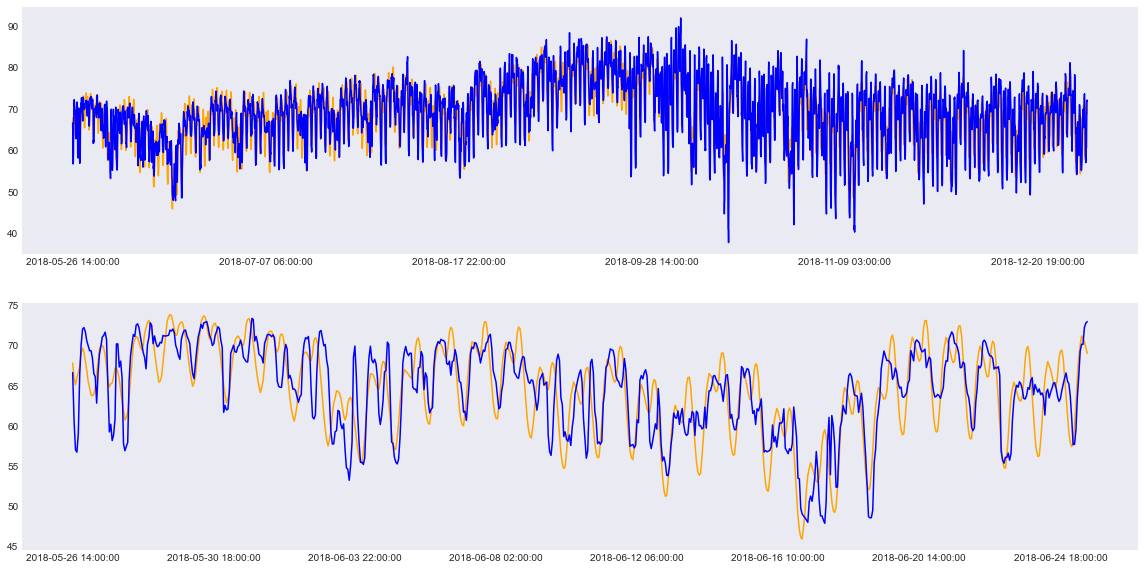

In [100]:
#Evaluate VAR performance on price_actual predictions
var_metrics = model_performance(var_forecasts['price_actual_predictions'].values, actual.values, 'VAR')

#Create figure
f, ax = plt.subplots(2,1,figsize = (20,10))

#Plot predictions
timeseries_plot(var_forecasts['price_actual_predictions'], ax = ax[0], color = 'orange')
timeseries_plot(X_test['price_actual'], ax = ax[0], color = 'blue')

timeseries_plot(var_forecasts['price_actual_predictions'][:24*30], ax = ax[1], color = 'orange')
timeseries_plot(X_test['price_actual'][:24*30], ax = ax[1], color = 'blue')


## Multivariate XGBoost

In [101]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29789 entries, 2015-01-01 12:00:00 to 2018-05-26 13:00:00
Data columns (total 43 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   generation_fossil_gas                                   29789 non-null  float64 
 1   generation_fossil_gas_stationary                        29789 non-null  float64 
 2   generation_fossil_hard_coal                             29789 non-null  float64 
 3   generation_fossil_hard_coal_stationary                  29789 non-null  float64 
 4   generation_hydro_pumped_storage_consumption             29789 non-null  float64 
 5   generation_hydro_pumped_storage_consumption_stationary  29789 non-null  float64 
 6   price_actual                                            29789 non-null  float64 
 7   price_actual_season                                     29789 non-null  float64 
 8  

**Prepare data**

In [127]:
###Prepare training data###
#Subset colds
X_train_boost = X_train.filter(regex = 'stationary|lag|month|weekday|holiday|(^year)|weekend')

#Drop NA
X_train_boost.dropna(inplace = True, axis = 0)

#Set target for multivariate xgboost and drop from X_train_boost
y_train_boost = X_train_boost['price_actual_stationary']
X_train_boost.drop(['price_actual_stationary'], axis = 1, inplace = True)

#check
print('Shape of Xgboost training data:{}\nShape of Xgboost training labels data:{}'.format(X_train_boost.shape,y_train_boost.shape))

Shape of Xgboost training data:(29765, 33)
Shape of Xgboost training labels data:(29765,)


In [126]:
###Prepare Test data###
#Subset colds
X_test_boost = X_test.filter(regex = 'stationary|lag|month|weekday|holiday|(^year)|weekend')

#Drop NA
X_test_boost.dropna(inplace = True, axis = 0)

#Set target for multivariate xgboost and drop from X_train_boost
y_test_boost = X_test_boost['price_actual_stationary']
X_test_boost.drop(['price_actual_stationary'], axis = 1, inplace = True)

#check
print('Shape of Xgboost training data:{}\nShape of Xgboost training labels data:{}'.format(X_test_boost.shape,y_test_boost.shape))

Shape of Xgboost training data:(5257, 33)
Shape of Xgboost training labels data:(5257,)


**Build pipeline**

Scale data
Dummy variables
feature select
fit XGBRegressor

In [129]:
#Import libraries
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from xgboost import XGBRegressor 

In [128]:
X_train_boost.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29765 entries, 2015-01-02 12:00:00 to 2018-05-26 13:00:00
Data columns (total 33 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   generation_fossil_gas_stationary                        29765 non-null  float64 
 1   generation_fossil_hard_coal_stationary                  29765 non-null  float64 
 2   generation_hydro_pumped_storage_consumption_stationary  29765 non-null  float64 
 3   total_load_actual_stationary                            29765 non-null  float64 
 4   year                                                    29765 non-null  category
 5   month                                                   29765 non-null  category
 6   weekday                                                 29765 non-null  category
 7   is_weekend                                              29765 non-null  bool    
 8  

In [143]:
scaler = Pipeline(steps= [('scaler',MinMaxScaler())])

encoder = Pipeline(steps= [('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('numeric', scaler, X_train_boost.select_dtypes('float64').columns),
                                              ('cat_bools', encoder, X_train_boost.select_dtypes(['bool','category']).columns)])

#Init XGBR
xgbr = XGBRegressor(n_jobs = -1, n_estimators=300, max_depth =7, learning_rate =0.1, randomstate = 23)

#One hot encode catagorical variables
pipe = Pipeline(steps= [('preprocessor',preprocessor), #Scale numeric datat
                           ('regressor', xgbr)]) #fit regressor


#Fit to training data
predictions = cross_val_predict(pipe, X_train_boost, y_train_boost, n_jobs=-1, cv=3)

#Store predictions in a data frame. Add seasonality and trend to predictions
#xgbr_predictions = pd.DataFrame(predictions, index=X_train_boost.index)

array([-0.4181034 , -0.08497775, -3.8676248 , ..., -0.82294893,
       -0.07435328,  0.8819231 ], dtype=float32)

In [153]:
pipe.named_steps['preprocessor'].transformers_[0][0]

AttributeError: 'ColumnTransformer' object has no attribute 'transformers_'

In [144]:
#Store predictions in a data frame. Add seasonality and trend to predictions
xgbr_predictions = pd.DataFrame(predictions, index=X_train_boost.index)
xgbr_predictions.columns = ['xgbr_raw_predictions']
xgbr_predictions['target'] = y_train_boost

xgbr_predictions

,xgbr_raw_predictions,target
date_time,,
2015-01-02 12:00:00,-0.418103,1.053625
2015-01-02 13:00:00,-0.084978,-1.327743
2015-01-02 14:00:00,-3.867625,-1.368354
2015-01-02 15:00:00,-2.081275,-0.505576
2015-01-02 16:00:00,-0.915033,-0.341468
...,...,...
2018-05-26 09:00:00,-1.684981,-1.333459
2018-05-26 10:00:00,-1.488424,-0.425243
2018-05-26 11:00:00,-0.822949,0.276229


In [25]:
xgbr = XGBRegressor()

parameters = {'n_estimators': [300],
             'max_depth' : [7],
             'learning_rate': [0.1]}



In [30]:
x_train

,price_actual_lag_2,price_actual_lag_3,price_actual_lag_4,price_actual_lag_5,price_actual_lag_6,price_actual_lag_7,price_actual_lag_8,price_actual_lag_9,price_actual_lag_10,price_actual_lag_11,price_actual_lag_12,price_actual_lag_13,price_actual_lag_14,price_actual_lag_15,price_actual_lag_16,price_actual_lag_17,price_actual_lag_18,price_actual_lag_19,price_actual_lag_20,price_actual_lag_21,price_actual_lag_22,price_actual_lag_23,price_actual_lag_24
date_time,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 12:00:00,5.458296,3.409201,5.815594,5.745723,-1.351044,-4.952089,-6.548968,-5.966306,-8.324765,-6.887727,-3.326082,-5.209646,0.633563,4.807601,8.378211,10.161748,12.193713,3.085689,-1.000426,-3.437243,-2.233563,-3.198368,-5.750750
2015-01-02 13:00:00,1.690138,5.458296,3.409201,5.815594,5.745723,-1.351044,-4.952089,-6.548968,-5.966306,-8.324765,-6.887727,-3.326082,-5.209646,0.633563,4.807601,8.378211,10.161748,12.193713,3.085689,-1.000426,-3.437243,-2.233563,-3.198368
2015-01-02 14:00:00,1.053625,1.690138,5.458296,3.409201,5.815594,5.745723,-1.351044,-4.952089,-6.548968,-5.966306,-8.324765,-6.887727,-3.326082,-5.209646,0.633563,4.807601,8.378211,10.161748,12.193713,3.085689,-1.000426,-3.437243,-2.233563
2015-01-02 15:00:00,-1.327743,1.053625,1.690138,5.458296,3.409201,5.815594,5.745723,-1.351044,-4.952089,-6.548968,-5.966306,-8.324765,-6.887727,-3.326082,-5.209646,0.633563,4.807601,8.378211,10.161748,12.193713,3.085689,-1.000426,-3.437243
2015-01-02 16:00:00,-1.368354,-1.327743,1.053625,1.690138,5.458296,3.409201,5.815594,5.745723,-1.351044,-4.952089,-6.548968,-5.966306,-8.324765,-6.887727,-3.326082,-5.209646,0.633563,4.807601,8.378211,10.161748,12.193713,3.085689,-1.000426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-26 09:00:00,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-1.773162,-0.300561,0.251866,-2.005368,-0.923563,-1.534201,-1.927000
2018-05-26 10:00:00,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-1.773162,-0.300561,0.251866,-2.005368,-0.923563,-1.534201
2018-05-26 11:00:00,-1.333459,-1.017779,-4.436287,-1.182674,2.641011,4.741973,6.384998,6.182495,7.719990,6.724111,4.979401,3.747898,2.075793,-2.983813,-5.369979,-6.251566,-7.327623,-3.964918,-1.773162,-0.300561,0.251866,-2.005368,-0.923563
